In [11]:
%matplotlib inline
import firedrake
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
from constants import *
from hs_solver import *
from phi_solver import *
from model import *

In [12]:
########### Domain Geometry ############
proj_dir = '/Volumes/hoffmaao/data/rd06/projects/thwiates_modeling/1Dhydrology/'
Lx = 50e3
nx =840
b0=0
b1=100
mesh = firedrake.IntervalMesh(nx,Lx)
degree = 1

V_cg = firedrake.FunctionSpace(mesh,"CG",degree)

In [13]:
# bed/surface topography, ice velocity and melt rates

H=firedrake.Function(V_cg)
B=firedrake.Function(V_cg)

x = firedrake.SpatialCoordinate(mesh)

H=firedrake.interpolate(10*firedrake.sqrt(x[0]),V_cg)

B=firedrake.interpolate(firedrake.Constant(b0),V_cg)


ub = firedrake.Function(V_cg)
m = firedrake.Function(V_cg)

ub=firedrake.interpolate((firedrake.Constant(10.0) + firedrake.Constant(240.0) * (50000.0 - x[0]) / firedrake.Constant(50000.0)) / firedrake.Constant(31536000.0),V_cg)
m = firedrake.interpolate((firedrake.Constant(1.0) + firedrake.Constant(1.5) * (50000.0 - x[0]) / firedrake.Constant(50000.0)) / firedrake.Constant(31536000.0),V_cg)


H_out = firedrake.File(proj_dir + "inputs/H.pvd")
B_out = firedrake.File(proj_dir + "inputs/B.pvd")

ub_out = firedrake.File(proj_dir + "inputs/ub.pvd")
m_out = firedrake.File(proj_dir + "inputs/m.pvd")

H_out.write(H)
B_out.write(B)
ub_out.write(ub)
m_out.write(m)

In [10]:
########### Model Initializtion ############


h_init = firedrake.Function(V_cg)
#h_init = firedrake.interpolate(.01/(1.0+x[0]),V_cg)
h_init = firedrake.interpolate(Constant(0.05),V_cg)

S_init = firedrake.Function(V_cg)
#S_init = firedrake.interpolate((.01*((50e3+1)-x[0])/50e3),V_cg)

phi_init = firedrake.Function(V_cg)


phi_init=pcs['g']*H*pcs['rho_ice'];

In [5]:
# Load potential at 0 pressure
phi_m = firedrake.Function(V_cg)
phi_m = B*pcs['g']*pcs['rho_water']
#ice overburden pressure
p_i = firedrake.Function(V_cg)
p_i = H*pcs['g']*pcs['rho_ice']+firedrake.Constant(.001)
# Enforce 0 pressure bc at margin
bc1 = firedrake.DirichletBC(V_cg, phi_m+p_i,1)
bc2 = firedrake.DirichletBC(V_cg, )
phi_init=firedrake.Function(V_cg)
phi_init=phi_m+p_i
pcs['k'] = firedrake.Constant(5e-4)
pcs['k_c'] = firedrake.Constant(0.05)



TypeError: __init__() missing 2 required positional arguments: 'g' and 'sub_domain'

In [ ]:
model_inputs = {}
model_inputs['phi_m'] = phi_m
model_inputs['p_i'] = p_i
model_inputs['phi_0'] = phi_m + p_i
model_inputs['mesh'] = mesh
model_inputs['H'] = H
model_inputs['B'] = B
model_inputs['u_b'] = ub
model_inputs['m'] = m
model_inputs['h_init'] = h_init
model_inputs['S_init'] = S_init
model_inputs['phi_init'] = phi_init
model_inputs['d_bcs'] = [bc]
model_inputs['maps_dir'] = proj_dir + "maps/"
model_inputs['out_dir'] = proj_dir + "outputs/"
model_inputs['constants'] = pcs
model_inputs['n_bc'] = []

In [ ]:
# Create the Glads model
model = Glads1DModel(model_inputs)
# End time
T = 25.0*pcs['spd']
# Time step
dt = 60.0
# Irataion count
i = 0

In [ ]:
plot(model.h)
plot(model.S)
plot(model.H)
plot(model.B)


In [6]:
############# Run simulation ################

while model.t < T:
    model.step(dt)
    print(model.t)

NameError: name 'model' is not defined

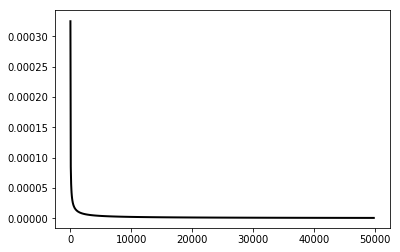

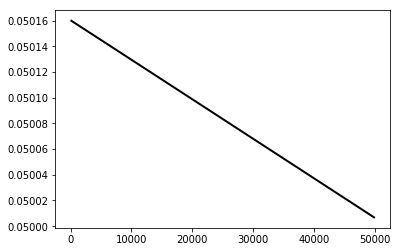

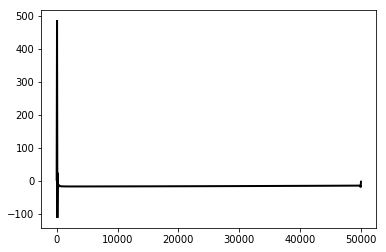

In [14]:
plot(model.S)
plot(model.h)
plot(model.N)

In [ ]:
phi_solver_1=PhiSolver(model)
# Get melt rate
m = model.m
# Sheet height
h = model.h
# Channel areas
S = model.S
# This function stores the value of S**alpha.
S_alpha = model.S_alpha
# Basal sliding speed
u_b = model.u_b
# Potential
phi = model.phi
# Potential at previous time step
phi_prev = model.phi_prev
# Potential at overburden pressure
phi_0 = model.phi_0
# Density of ice
rho_i = model.pcs['rho_ice']
# Density of water
rho_w = model.pcs['rho_water']
# Rate factor
A = model.pcs['A']
# Sheet conductivity
k = model.pcs['k']
# Channel conductivity
k_c = model.pcs['k_c']
# Bump height
h_r = model.pcs['h_r']
# Distance between bumps
l_r = model.pcs['l_r']
# Sheet width under channel
l_c = model.pcs['l_c']
# Latent heat
L = model.pcs['L']
# Width of distributed drainage
#W = model.pcs['W']
# Void storage ratio
e_v = model.pcs['e_v']
# Gravitational acceleration
g = model.pcs['g']
# Exponents
alpha = model.pcs['alpha']
delta = model.pcs['delta']
# pcs in front of storage term
c1 = e_v / (rho_w * g)
# Regularization parameter
phi_reg = 1e-15
  
### set up sheet model
# Expression for effective pressure in terms of potential
N = phi_0 - phi
# Derivative of phi
dphi_tmp = phi.dx(0)
#dphi_ds = firedrake.interpolate(dphi_tmp,V_cg)
# Flux vector
#q = -firedrake.Constant(k) * h**alpha * abs(dphi_ds + phi_reg)**(delta) * dphi_ds
q = -firedrake.Constant(k) * h**alpha * abs(phi.dx(0) + phi_reg)**(delta) * phi.dx(0)
# Opening term 
w = firedrake.conditional(firedrake.gt(h_r - h, 0.0), u_b * (h_r - h) / l_r, 0.0)
# Closing term
v = firedrake.Constant(A) * h * N**3



### Set up the channel model 

# Discharge through channels
Q = -firedrake.Constant(k_c) * S_alpha * abs(phi.dx(0) + firedrake.Constant(phi_reg))**delta * phi.dx(0)
# Approximate discharge of sheet in direction of channel
q_c = -firedrake.Constant(k) * h**alpha * abs(phi.dx(0) + firedrake.Constant(phi_reg))**delta * phi.dx(0)
# Energy dissipation 
Xi = abs(Q * phi.dx(0)) + abs(firedrake.Constant(l_c) * q_c * phi.dx(0))
# Channel creep closure rate
v_c = firedrake.Constant(A) * S * N**3
# Another channel source term
w_c = (Xi / firedrake.Constant(L)) * firedrake.Constant((1. / rho_i) - (1. / rho_w))

### Set up the PDE for the potential ###

# Measure for integrals over mesh boundaries
#ds = firedrake.Measure("ds")[model.boundaries]
#dx = firedrake.Measure('dx',domain=model.mesh)
theta = firedrake.TestFunction(model.V_cg)

# Constant in front of storage term
C1 = firedrake.Constant(c1)
# Storage term
F_s = C1 * (phi - phi_prev) * theta * firedrake.dx
# Sheet contribution to PDE
F_s += dt * (-theta.dx(0) * q + (w - v - m) * theta) * firedrake.dx 

# Add any non-zero Neumann boundary conditions
for (m, c) in model.n_bcs: 
    F_s += dt * firedrake.Constant(c) * theta * m

# Channel contribution to PDE
F_c = dt * ((-theta.dx(0)) * Q + (w_c - v_c) * theta('+') )* firedrake.dx
# Variational form
F = F_s + F_c

# Get the Jacobian
dphi = firedrake.TrialFunction(model.V_cg)
J = firedrake.derivative(F_s, phi, dphi) 


### Assign local variables

phi_solver_1.F = F_s
phi_solver_1.J = J
phi_solver_1.model = model
phi_solver_1.dt = 40
phi_solver_1.model.d_bcs

In [ ]:
solve(phi_solver_1.F == 0, phi_solver_1.model.phi, phi_solver_1.model.d_bcs, J = phi_solver_1.J,solver_parameters={
                         'snes_type': 'newtonls',
                         'snes_rtol': 5e-11,
                         'snes_atol': 5e-10,
                         'pc_type': 'lu',
                         'snes_max_it': 50,
                         'mat_type': 'aij'})

In [ ]:
plot(model.phi)
plot(model.S)
plot(model.h)
plot(model.N)